In [12]:
# 1. ライブラリの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# グラフのスタイル設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 2. データの読み込み
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# データの確認
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


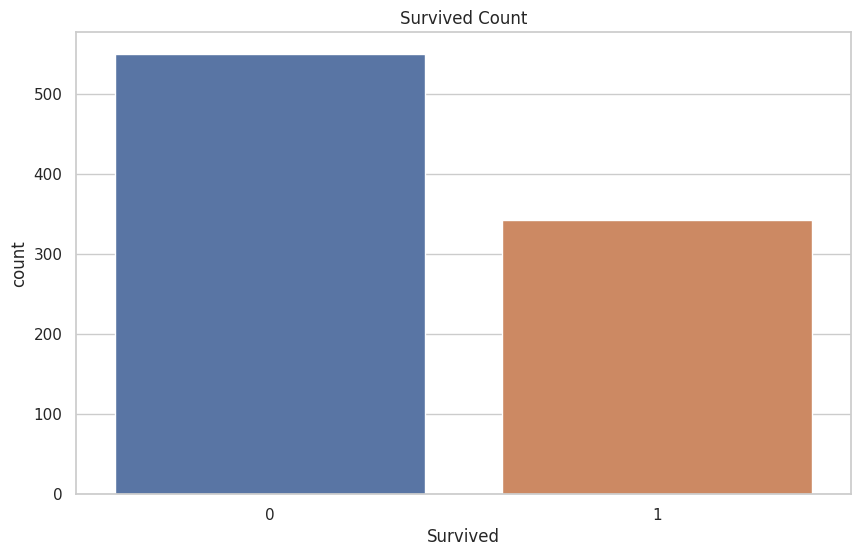

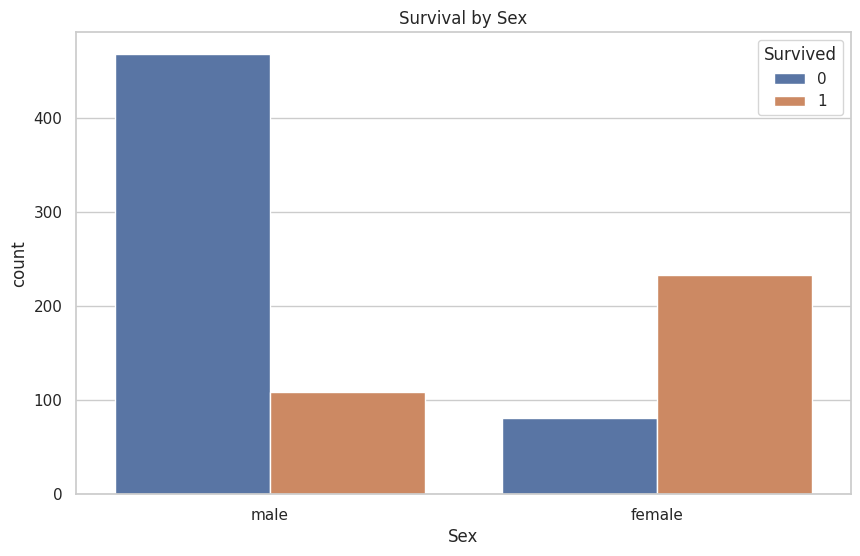

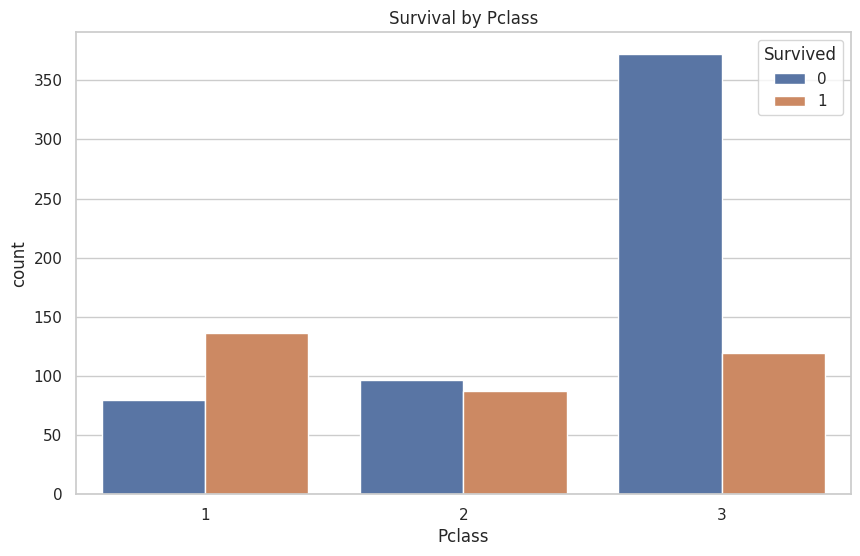

In [13]:
# 欠損値の確認
print(train.isnull().sum())

# 生存者の割合
sns.countplot(data=train, x="Survived")
plt.title("Survived Count")
plt.show()

# 性別と生存率
sns.countplot(data=train, x="Sex", hue="Survived")
plt.title("Survival by Sex")
plt.show()

# Pclass（チケットのクラス）と生存率
sns.countplot(data=train, x="Pclass", hue="Survived")
plt.title("Survival by Pclass")
plt.show()


In [14]:
# 3. データ前処理（欠損補完＋カテゴリ処理）
# 性別を数値化
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

# 年齢の欠損 → 中央値
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())

# 乗船港の欠損 → 最頻値"S"
train["Embarked"] = train["Embarked"].fillna("S")

# 乗船港を数値に変換
train["Embarked"] = train["Embarked"].map({"S": 0, "C": 1, "Q": 2})
test["Embarked"] = test["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# 料金の欠損 → 中央値
test["Fare"] = test["Fare"].fillna(test["Fare"].median())


In [15]:
# 欠損値の再確認
print(train.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [16]:
# 4. 特徴量エンジニアリング

## A. Title（敬称）の抽出と数値化
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

for df in [train, test]:
    df["Title"] = df["Title"].replace(['Lady', 'Countess','Capt','Col',
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].replace(['Mlle', 'Ms'], 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')

title_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
train["Title"] = train["Title"].map(title_map).fillna(0)
test["Title"] = test["Title"].map(title_map).fillna(0)

## B. FamilySize
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

## C. IsAlone
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)


In [17]:

# 5. 特徴量選択
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Title", "FamilySize", "IsAlone"]
X = train[features]
y = train["Survived"]
X_test = test[features]

# 6. モデル学習・予測
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
model.fit(X, y)
pred = model.predict(X_test)

# 7. 提出ファイル作成
submission["Survived"] = pred
submission.to_csv("/kaggle/working/submission.csv", index=False)